# The new old songs.

Task’s description: This is time series temperature sensor data for a __single__ _device in a store_. _High temperature_ can cause __problems__ and lead to _service tickets_ in the __future__.
How could you detect if and when problems occur and on which device? Is there a bad device present? If so, when did the problem occur?

## Landing the problem (from business and technical perspective).

First of all, thank you very much for the data sample that was shared with me. Since high temperatures are our focus as they cause [problems](https://www.globalknowledge.com/us-en/resources/resource-library/articles/how-itil-differentiates-problems-and-incidents/#gref), inside or outside the ITIL definition, the goal is to decrease them. In order to find the __root cause of the incidents__ and therefore the tickets derived from it in the first instance, in a second stage after solving this problem, this saved time could be used to generate another service or improve another within the business.

Adrian shared with me by email that several factors can affect the data sent by the sensors as well as having a laboratory where you have conditions where you can have 'ideal' measurements of the sensors which can be used as a baseline for A/B test, or to determine the lifetimes in ideal conditions of the different types of sensors and in this case to determine a __threshold value__ $\alpha_k$ that allows to decide if the type of sensor $k$ registers a high temperature.

Let us define the event of registering a high temperature as `Positive`, so we can call `False Negative` the fact of registering a high temperature of a sensor that has a low temperature, to which we must pay much attention because they are the measurements that __will generate the tickets in the system__ (and it is the issue we are focused on). On the other hand, we can call the registration of low temperatures by sensors that have high temperatures `False positive`, which is also important as this may imply damage to the hardware.

Suppose that the thresholds $\alpha_k$ were determined by non-parametric statistical tests, since the data with which we are working do not meet the __traditional conditions__ of normality and are mostly autocorrelated (by the measurement time) or, by means of a classifier using the [F-score](https://en.wikipedia.org/wiki/F-score).


### How could you detect if and when problems occur and on which device?
If a failure in the $ k $ type sensor is suspected in time $ t $ and the threshold $\alpha_k$ is available, the sensor history $k$ will be reviewed, if it is a false negative, the cost will be evaluated of physical interaction to repair it, in case it is high, several devices with the same type of recent failure could be searched for the cost of the visit to be viable. If a false positive is detected, it would be evaluated not to issue the ticket and analyze devices with similar failures to find the root of the problem: such as the lifetime of the devices in the store or their spatial distribution in the store.

If the threshold $\alpha_k$ is not available, I would suggest clustering the devices in the store and determining them by the means mentioned in previous paragraphs.

An advantage or disadvantage that we have of this type of measurements is that they are time series, so they are correlated, so a device that has presented a failure in time $t$ if it is not corrected is very likely to present failures in the time $t^*> t$.


## Frontlog

In general, about the data that was shared with me, _I have several doubts about how the samples were generated_, for example for this task the measurement times are not equally spaced but they are not randomly selected either, so _I infer that it is currently implemented. a sampling system for data collection_, since although it is possible to do so, it does not add value to record all the data from the sensors, in addition to being impractical it implies economic costs and resources such as time and money.

It was decided to use R in this task because the framework for working with time series is larger than the existing one in Python, in my experience, in addition to the fact that the dataset is small, because as we know R scales not so easily.





In [1]:
# Requirements
#lapply(FUN=install.packages,c('ggplot2','lubridate', 'dplyr', 'tidyr'))
library(tidyr)
library(lubridate) # handle date very easy
library(ggplot2) # nice and Functional plots!
library(dplyr) # like SQL in R
options(repr.plot.width=12, repr.plot.height=8)
path <- 'C:/Users/user/Desktop/GitHub/Toshiba' # home path 


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
device.data <- read.csv( paste0(path, '/Data/DeviceTelemetry.csv') , header = FALSE) # data folder 
print(dim(device.data)) # small data THANKS A LOT GUYS :)! 
head(device.data)

[1] 104   2


,V1,V2
,<chr>,<dbl>
1,ï»¿2019-11-21T05:20:01Z,17.4
2,2019-11-21T05:22:01Z,15.6
3,2019-11-21T05:24:01Z,19.7
4,2019-11-21T05:26:01Z,21.7
5,2019-11-21T05:28:01Z,19.7
6,2019-11-21T05:31:01Z,20.6


In [3]:
names(device.data) <- c('time', 'temp')
print (sum ( is.na(device.data) ) ) # non nulls THANKS guys
print( sum (table( device.data$time) > 1) ) 

[1] 0
[1] 0


In [4]:
print(summary( device.data$temp))
device.data$time <- ymd_hms(device.data$time)
print(summary( device.data$time))
print(max(device.data$time) - min(device.data$time))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.10   18.52   19.95   19.37   20.30   21.70 
                 Min.               1st Qu.                Median 
"2019-11-21 05:20:01" "2019-11-21 06:43:46" "2019-11-21 07:45:01" 
                 Mean               3rd Qu.                  Max. 
"2019-11-21 07:58:22" "2019-11-21 09:09:16" "2019-11-21 10:52:01" 
Time difference of 5.533333 hours


Given that the threshold $\alpha_k$ for the type of device $k$ of the provided dataset is unknown, to affirm that a temperature measurement is high, by the [Markov's inequality](https://en.wikipedia.org/wiki/Markov%27s_inequality) we can affirm that 92% of the measurements will be less than 21 if we estimated the distribution expectation by the mean, with a probability greater than 0.92

In [5]:
temp.sd <- sd( device.data$temp )
temp.mean <- mean( device.data$temp ) 
print(temp.mean/21)

[1] 0.9223443


### Non a traditional six sigma case ! :D

5%    10%    90%    95%    97%    98%    99% 
15.940 17.400 20.600 20.700 20.791 21.364 21.497

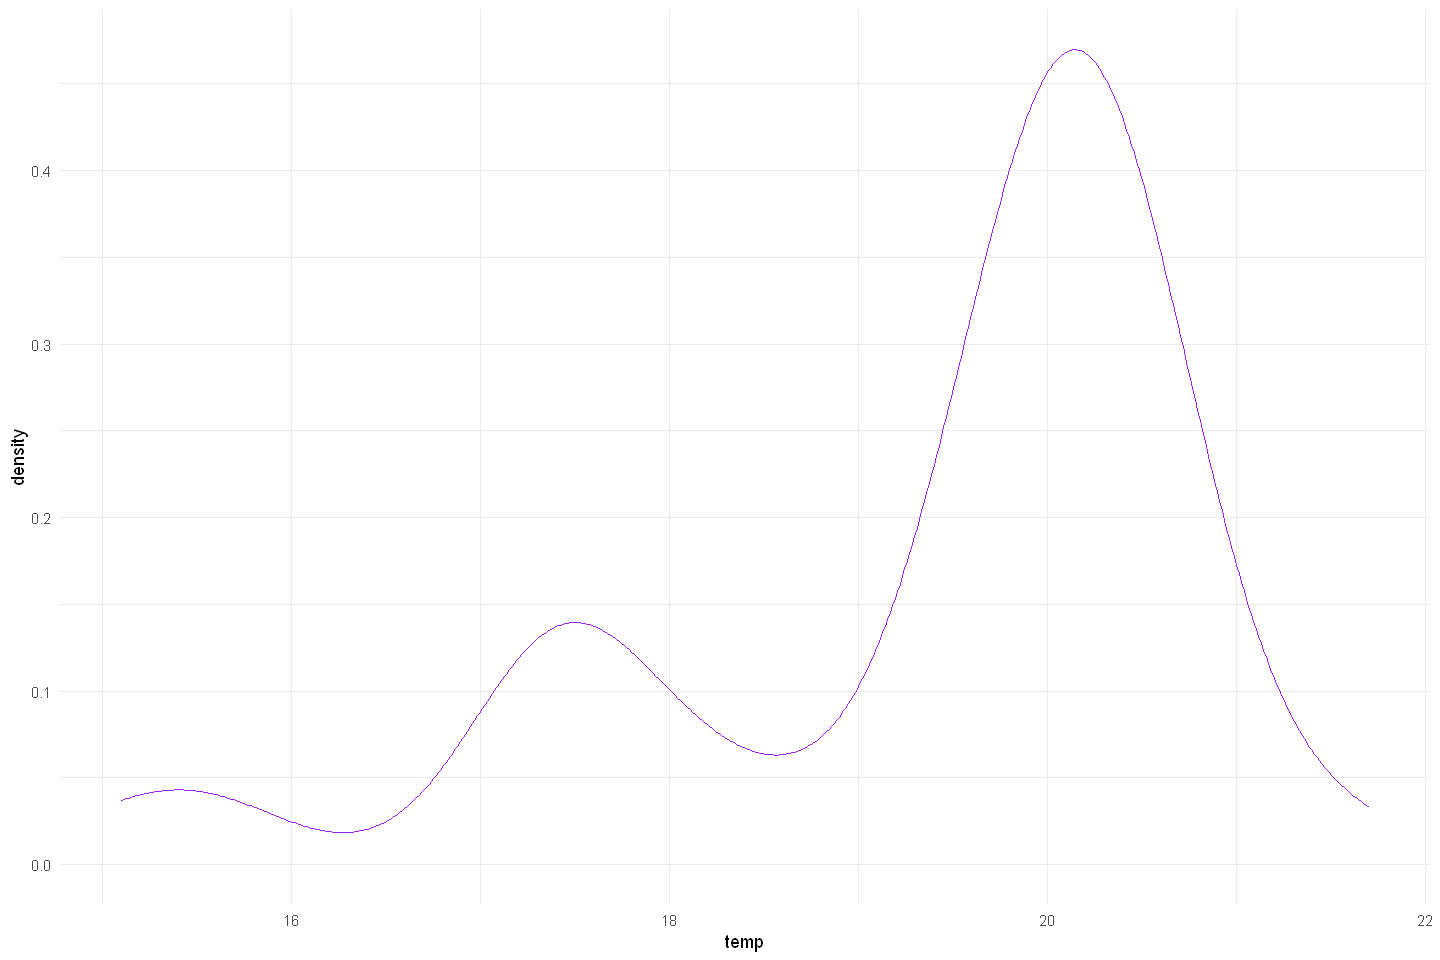

In [6]:
ggplot(device.data,aes( x=temp, colour=I('purple') ) ) + geom_density() + theme_minimal() 
quantile(device.data$temp, p=c(0.05, .1,.9, .95, .97, .98, .99))

From the empirical distribution of the recorded temperatures, we can see that it is a negatively skewed distribution, in addition to being __trimodal__, so it is expected to observe at __least three phenomena or factors that are altering this measurement__, that of very low values (<16), those that are between 16 and 18, those that appear more frequently around the value 20 and finally the very high> 21.

In [7]:
device.data %>% arrange(time) %>% mutate( time.dif = time - lag (time)) -> device.data 
print(summary(as.numeric(device.data$time.dif)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   2.000   3.223   4.000  26.000       1 


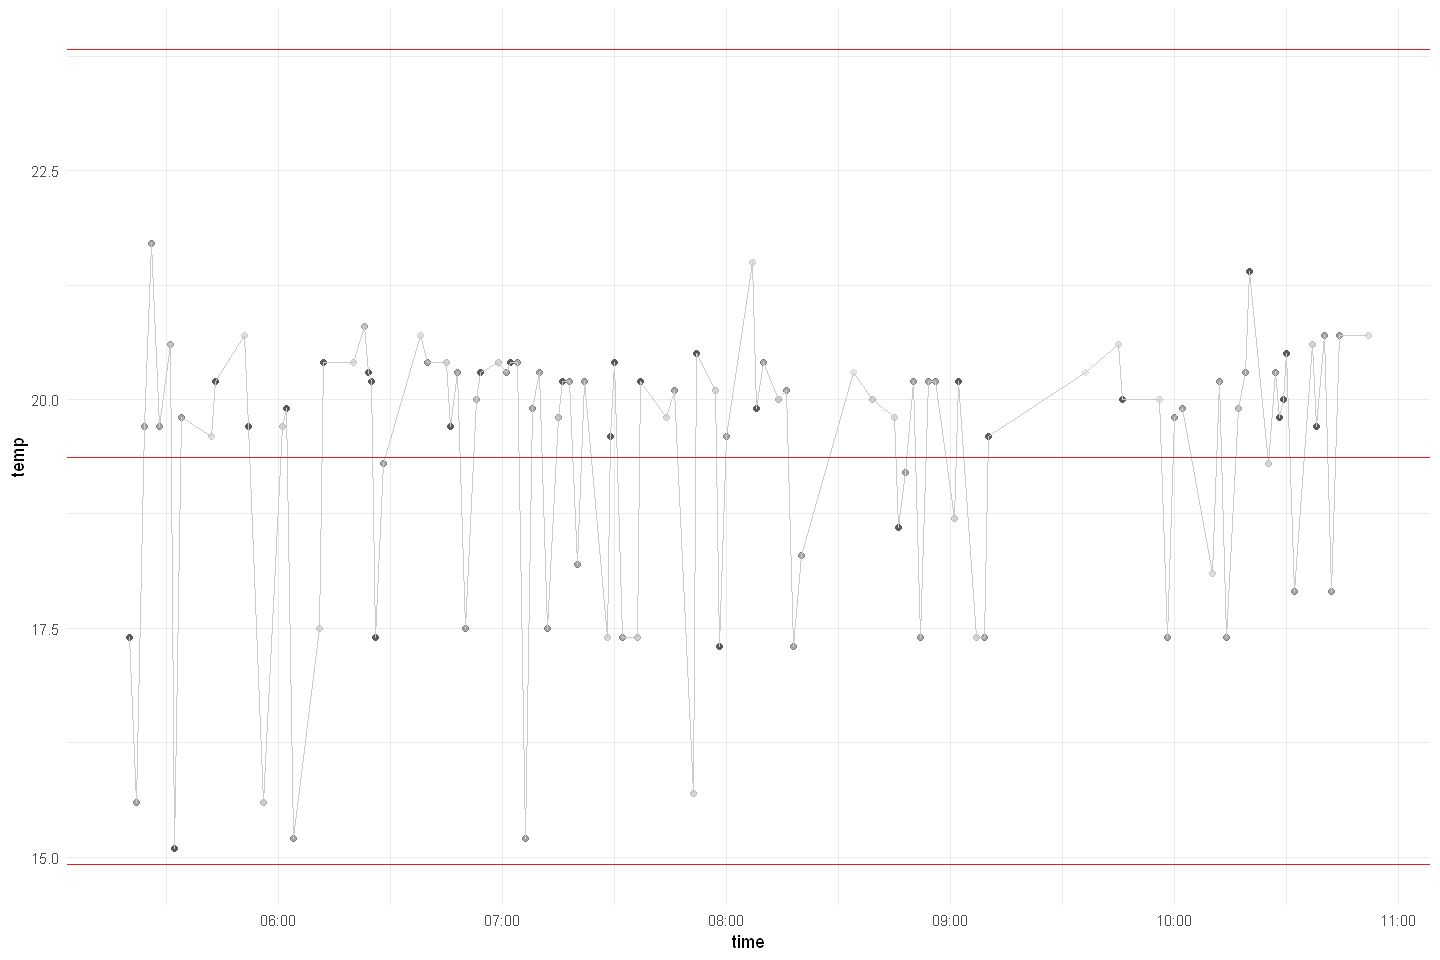

In [8]:
ggplot(device.data, aes( x=time, temp)) + 
    geom_point(aes(colour=I('#5A5A5A'), alpha= 2/as.numeric(time.dif) ))+
    geom_line(aes(colour=I('#CBCBCB')))  +
    geom_hline(aes(yintercept=temp.mean,  colour=I('#E91E1E'))) + 
    geom_hline(aes(yintercept=temp.mean + temp.sd*3,  colour=I('#E91E1E'))) +
    geom_hline(aes(yintercept=temp.mean - temp.sd*3,  colour=I('#E91E1E'))) + theme_minimal()+
    theme(legend.position ='none') 

In the upper graph we can see all the measurements in the interval, where the intensity of the points represents the difference between the times $t$ and $t-1$, so we can see that the measurements with the greatest intensity are precisely those that are between 19 and 21. In addition to the 6 points with value less than 16, only one of them has a 'high' intensity, on these measurements it is worth noting that they only occur up to the middle of the interval, which could be associated with the period hardware calibration or with the dynamics of the customers in the store.

What is very important to note are the three points with the highest value, only one of them has a high intensity in color and the three present a previous and later reading, respectively, within the set of values around 20, which can be interpreted as possible measurement failures.


Therefore, I will use a non-parametric method, Bootstrap, to determine the threshold from which to define when a high reading is a False negative, that is, it is a high reading when it really is not and this generates a ticket and of course unnecessary work.

In [9]:
# Bootstrap function
set.seed(0)
bs <- function(x) {
  muestra <- device.data[sample(1:nrow(device.data), replace=TRUE),]
  data.frame(temp=muestra$temp, time=muestra$time, Sample=x)
}
n <-10000
data <- lapply(FUN=bs, 1:n)
data <- do.call(rbind, data)

In [10]:
data %>% group_by( Sample) %>% summarise(means=mean(temp), mins=min(temp), maxs=max(temp)) -> device.bs
summary(device.bs)

`summarise()` ungrouping output (override with `.groups` argument)



     Sample          means            mins            maxs      
 Min.   :    1   Min.   :18.75   Min.   :15.10   Min.   :20.70  
 1st Qu.: 2501   1st Qu.:19.27   1st Qu.:15.10   1st Qu.:21.50  
 Median : 5000   Median :19.37   Median :15.10   Median :21.70  
 Mean   : 5000   Mean   :19.37   Mean   :15.16   Mean   :21.58  
 3rd Qu.: 7500   3rd Qu.:19.47   3rd Qu.:15.20   3rd Qu.:21.70  
 Max.   :10000   Max.   :19.87   Max.   :17.40   Max.   :21.70  

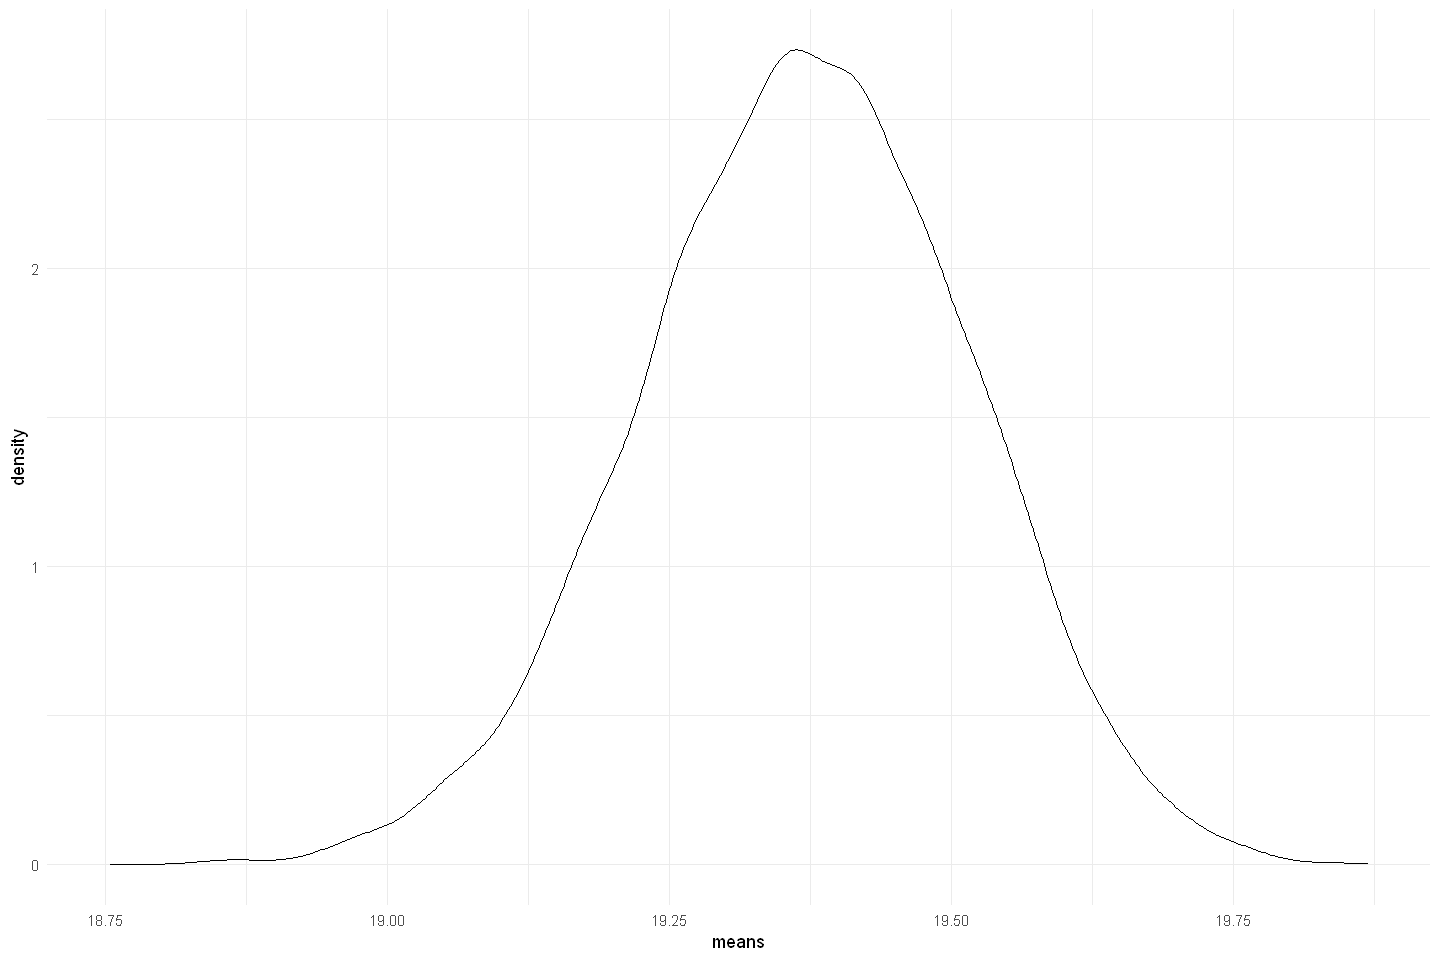

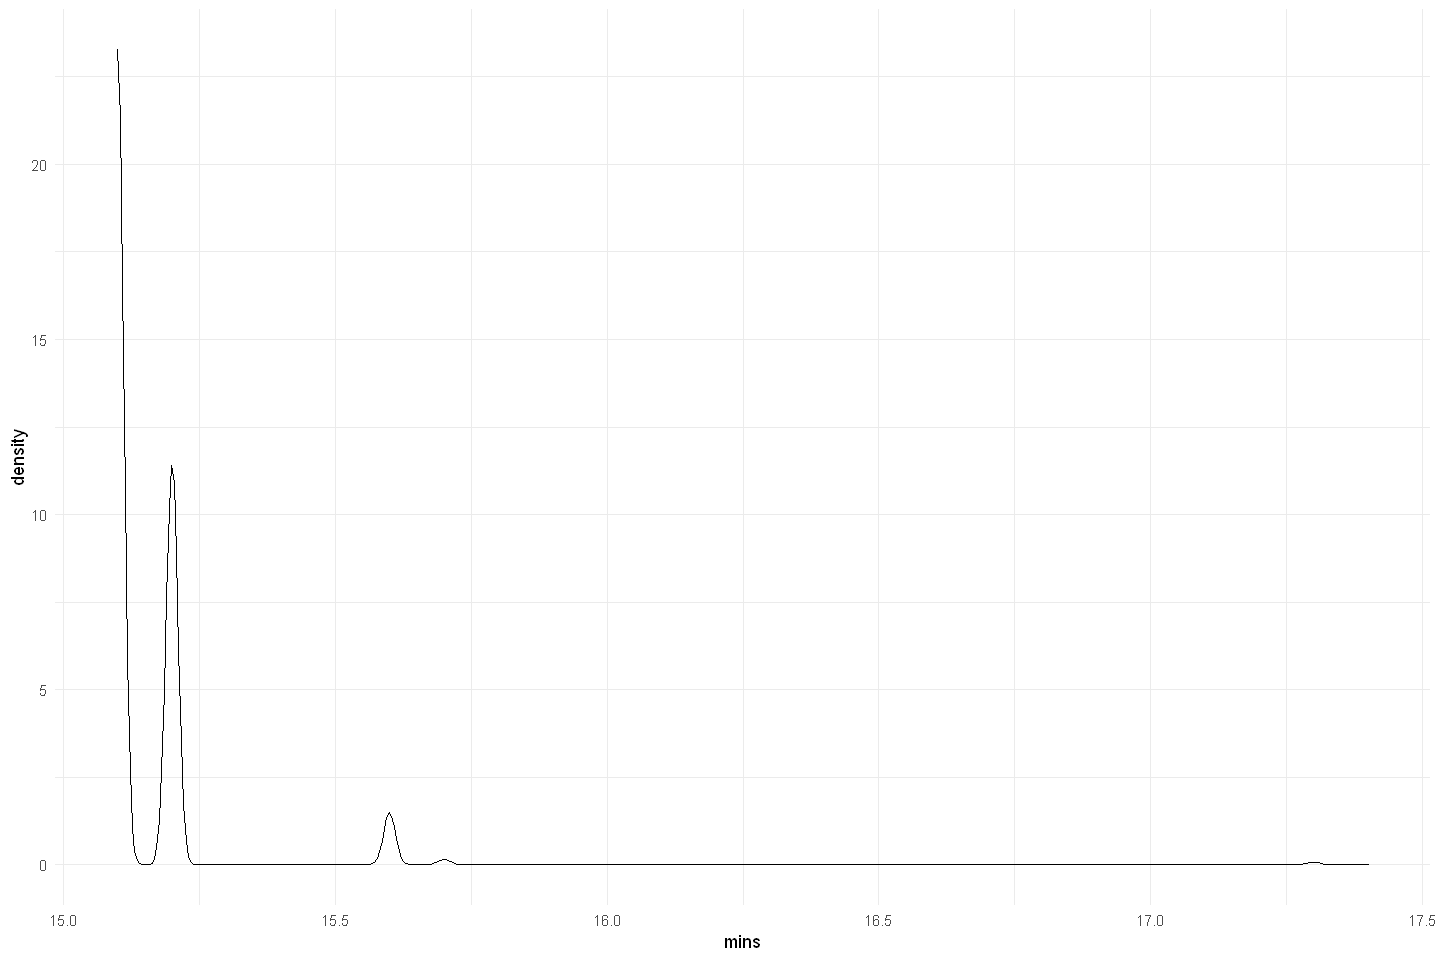

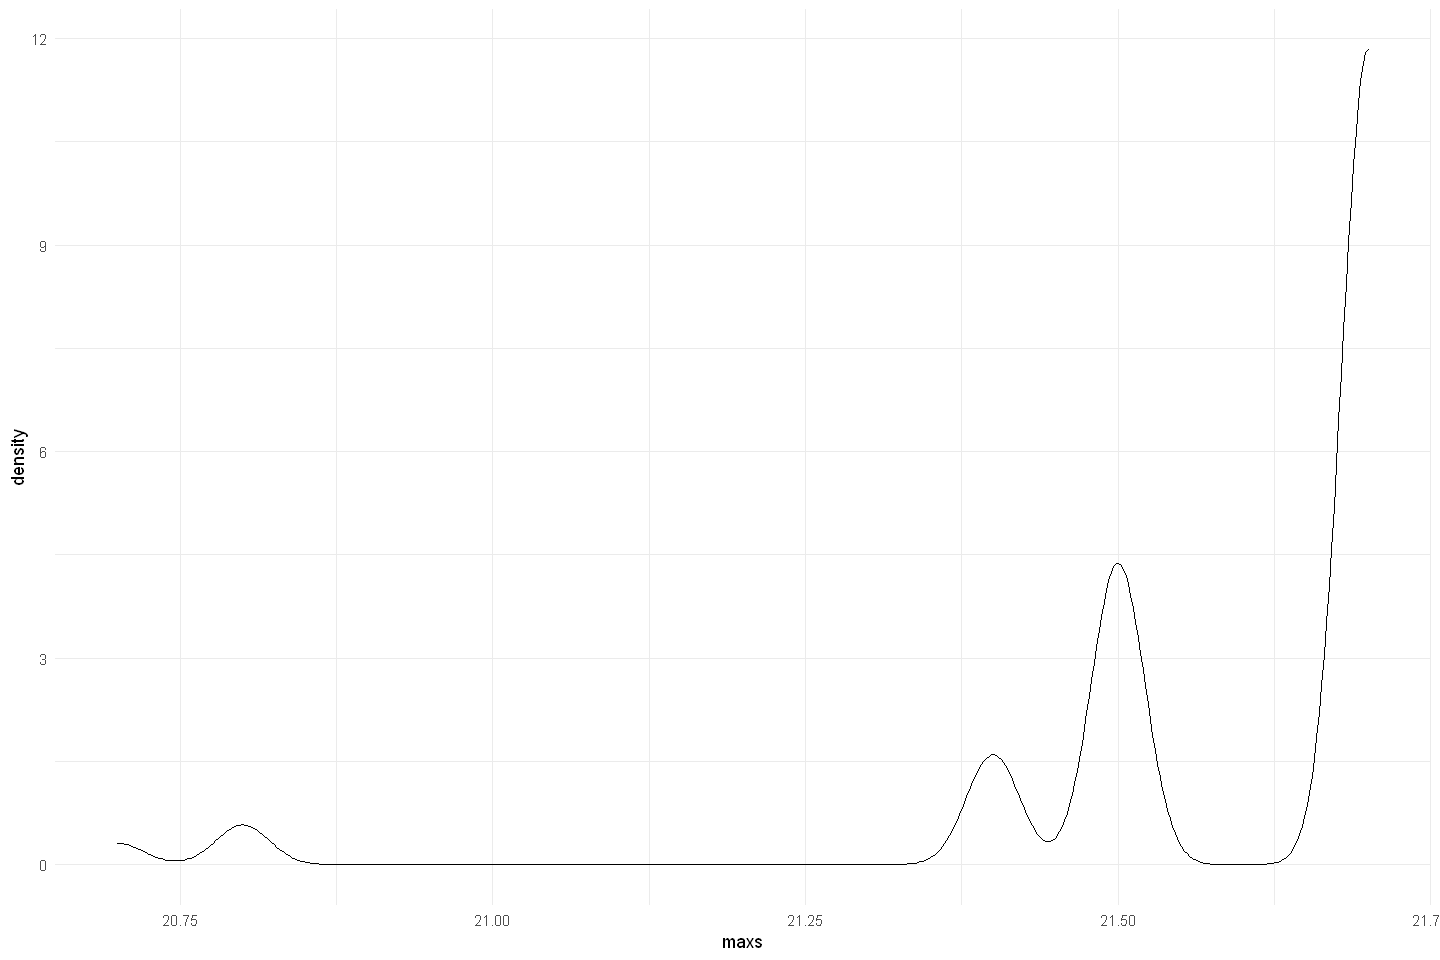

In [11]:
ggplot(device.bs, aes(means)) + geom_density() + theme_minimal()
ggplot(device.bs, aes(mins)) + geom_density()  + theme_minimal()
ggplot(device.bs, aes(maxs)) + geom_density()  + theme_minimal()

After resampling 20,000 from the original sample, we can notice that the mean value of these bootstrap replicas is quite stable, around 19.37 just the mean value of the original sample. The interesting thing is that the distribution of the minimum values of the bootstrap replicas is a very negatively skewed distribution, which allows us to infer that this phenomenon is normal in the sensors and may be due to their operation, such as their configuration, and we can associate them with the first mode (left) in the first graphic of this notebook.

The most interesting thing is that the distribution of the bootstrap replicas for the maximum values has more modes than the original distribution of the measurements, so it contains more noise in the measurements or uncontrolled variance in the data, in addition to its distribution does not explain the right tail of the original distribution of the data.

__From the bootstrap replicas we can finally set the threshold value $\alpha_k = 20.7$ which is the minimum of the maximum values obtained via bootstrap.__


### Is there a bad device present? If so, when did the problem occur?

I think yes. The sensor from which the data was shared with me is damaged.
And the problems arose in the following times:


In [12]:
threshold <- min(device.bs$maxs)
device.data %>% filter( temp > threshold) -> picture
picture

time,temp,time.dif
<dttm>,<dbl>,<drtn>
2019-11-21 05:26:01,21.7,2 mins
2019-11-21 06:23:01,20.8,3 mins
2019-11-21 08:07:01,21.5,7 mins
2019-11-21 10:20:01,21.4,1 mins


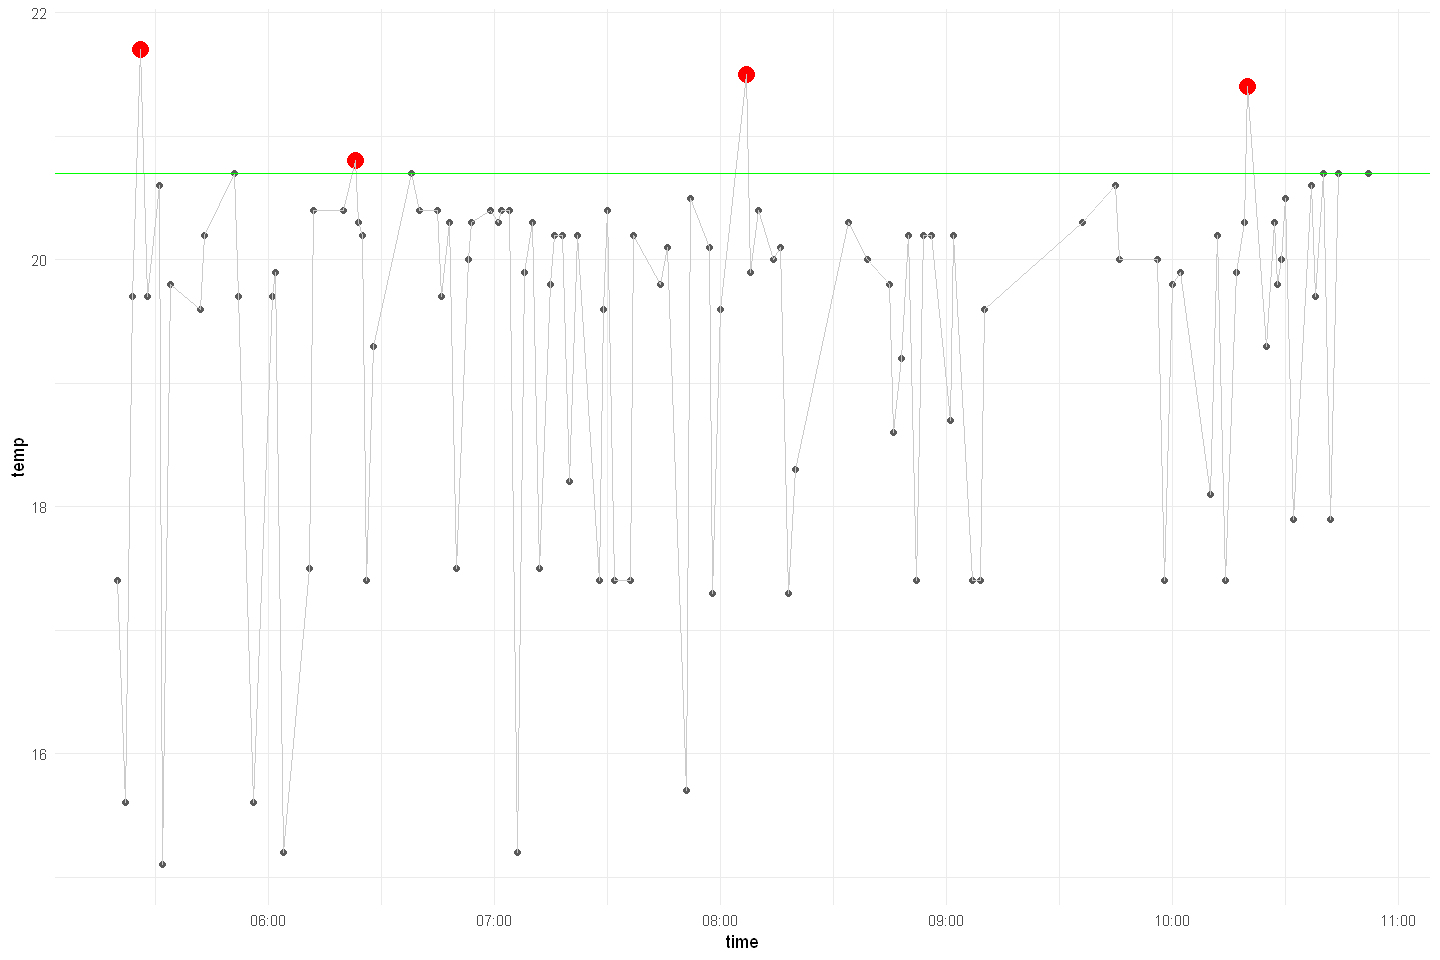

In [13]:
ggplot(device.data, aes( x=time, temp)) + 
    geom_point(aes(colour=I('#5A5A5A')) )+
    geom_point(data=picture, aes(colour=I('red'), size=1) )+
    geom_line(aes(colour=I('#CBCBCB')))  +
    geom_hline(aes(yintercept=20.7,  colour=I('green')))+ theme_minimal()+
    theme(legend.position ='none') 

# Sharing results and lessons learned

It is always good to research the audience to which the results will be presented, their interests, background and above all to take care and plan the presentation times.

To present the results obtained, I would use a graph like the last one shown, previously I would analyze in greater detail the history of this device and similar cases to propose this decrease in tickets that could impact up to 3.8%

Personally, I used to invite the audience to ask their questions as soon as they come up, because in my experience, if they leave them until last, they tend to forget them and that can reduce engagement with the presentation.

In addition to the presentation, I would make sure the team has the data that support the graphics on hand in case questions arise on the go.
